# Support Vector Machines

In [142]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plot_multiple_images, generateRings, scatter_label_points, loadMNIST
%matplotlib inline

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF and linear below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$ for the RBF kernel and $k(x_i,y_j)= x_i^{\top}y_j$ for the linear kernel. (The fastest solution does not use any for loop!)

In [14]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        # We use here vectorized operations instead of loops for optimization 
        # Compute pairwise squared Euclidean distances
        X_norm = np.sum(X**2, axis=1)[:, np.newaxis]  # Shape (N, 1)
        Y_norm = np.sum(Y**2, axis=1)[np.newaxis, :]  # Shape (1, M)
        distances = X_norm + Y_norm - 2 * np.dot(X, Y.T)  # Shape (N, M)

        # Compute the RBF kernel
        G = np.exp(-distances / (2 * self.sigma**2))
        return  G

In [13]:
class Linear:
    def kernel(self,X,Y):
        G = np.dot(X,Y.T)    
        return G


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [103]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None # support vectors
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X) # the gram matrix 
        self.X = X
        self.y = y
        # Lagrange dual problem
        def loss(alpha):
            s_1 = np.sum(alpha)

            weighted_labels = y*alpha
            s_2=np.dot(weighted_labels.T,np.dot(K,weighted_labels))

            return  s_1-(1/2)*s_2

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            weighted_labels = y*alpha
            return 1 - y * np.dot(K,weighted_labels)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha:  np.dot(y,alpha) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  y   #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha:  np.hstack([self.C-alpha,alpha]) # '''---------------function defining the inequality constraint-------------------'''     
        jac_ineq = lambda alpha:  np.vstack([-np.eye(N),np.eye(N)]) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes

        #'''------------------- A matrix with each row corresponding to support vectors ------------------'''

        self.support =  X[self.alpha>0] 

        #''' -----------------offset of the classifier------------------ '''

        ind1 = self.alpha>0
        ind2 = self.alpha<self.C
        ind_verif = ind1*ind2 # datapoints having their respective 0<alpha_i<C
        indices = np.arange(N)[ind_verif]
        f_opt = lambda i: np.dot(K[i],y*self.alpha)

        self.b = np.mean(1/y[indices]-f_opt(indices)) 

        # '''------------------------RKHS norm of the function f ------------------------------'''

        weighted_labels = y*self.alpha

        self.norm_f = np.dot(weighted_labels.T,np.dot(K,weighted_labels)) 

    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K_pred = self.kernel(self.X,x).T
        return np.dot(K_pred,self.alpha*self.y)
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

# 2 b- Implementing the visualization function
Implement the function plotClassification that takes new data as input and the model, then displays separating function and margins along with misclassified points.

In [135]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import seaborn as sns

def plotHyperSurface(ax, xRange, model, intercept, label, color='grey', linestyle='-', alpha=1.):
    #xx = np.linspace(-1, 1, 100)
    if model.type=='linear':
        xRange = np.array(xRange)
        yy = -(model.w[0] / model.w[1]) * xRange  - intercept/model.w[1]
        ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    else:
        xRange = np.linspace(xRange[0], xRange[1], 100)
        X0, X1 = np.meshgrid(xRange, xRange)
        xy = np.vstack([X0.ravel(), X1.ravel()]).T
        Y30 = model.separating_function(xy).reshape(X0.shape) + intercept
        ax.contour(X0, X1, Y30, colors=color, levels=[0.], alpha=alpha, linestyles=[linestyle]);


def plotClassification(X, y, model=None, label='',  separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    colors = ['blue','red']
    labels = [1,-1]
    cmap = pltcolors.ListedColormap(colors)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(11, 7))
    for k, label in enumerate(labels):
        im = ax.scatter(X[y==label,0], X[y==label,1],  alpha=0.5,label='class '+str(label))

    if model is not None:
        # Plot the seprating function
        plotHyperSurface(ax, bound[0], model, model.b, separatorLabel)
        if model.support is not None:
            ax.scatter(model.support[:,0], model.support[:,1], label='Support', s=80, facecolors='none', edgecolors='r', color='r')
            print("Number of support vectors = %d" % (len(model.support)))
        # Plot the margins
        supp_pred = model.predict(model.support)
        supp_neg = model.support[supp_pred==-1]
        supp_pos = model.support[supp_pred==1]

        intercept_neg = -np.max(model.separating_function(supp_neg))    ### compute the intercept for the negative margin
        intercept_pos = -np.min(model.separating_function(supp_pos))   ### compute the intercept for the positive margin
        xx = np.array(bound[0])
        plotHyperSurface(ax, xx, model, intercept_neg , 'Margin -', linestyle='-.', alpha=0.8)
        plotHyperSurface(ax, xx, model, intercept_pos , 'Margin +', linestyle='--', alpha=0.8)
            
        # Plot points on the wrong side of the margin
        y_pred = model.predict(X)
        wrong_side_points = X[y_pred!=y]# find wrong points
        ax.scatter(wrong_side_points[:,0], wrong_side_points[:,1], label='Beyond the margin', s=80, facecolors='none', 
               edgecolors='grey', color='grey')
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])

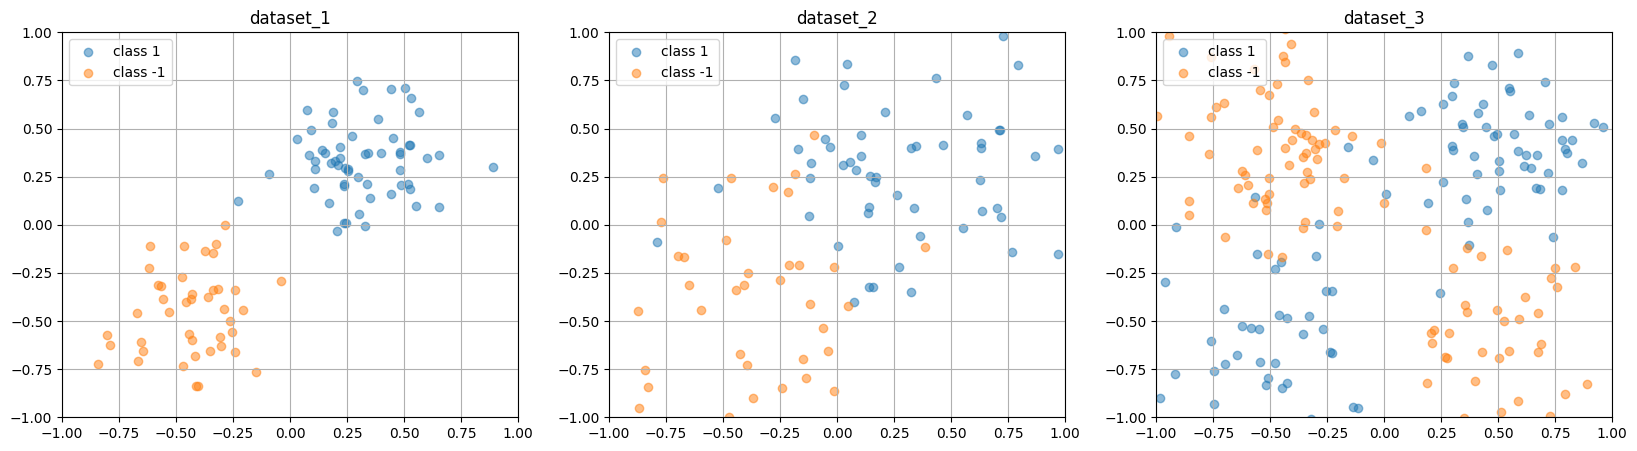

In [119]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
fig, ax = plt.subplots(1,3, figsize=(20, 5))
for i, (name, dataset) in enumerate(datasets.items()):
    
    plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax[i])
    ax[i].set_title(name)

### 3- Fitting the classifier

Run the code block below to fit the classifier and report its output.

### Dataset 1
#### Linear classifier

Number of support vectors = 84


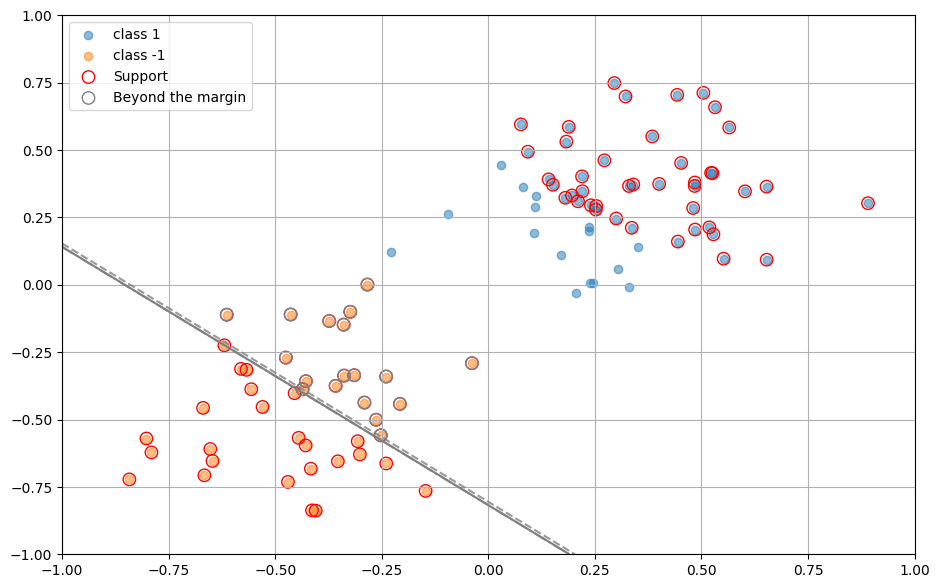

In [136]:
C=1.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian classifier

Number of support vectors = 88


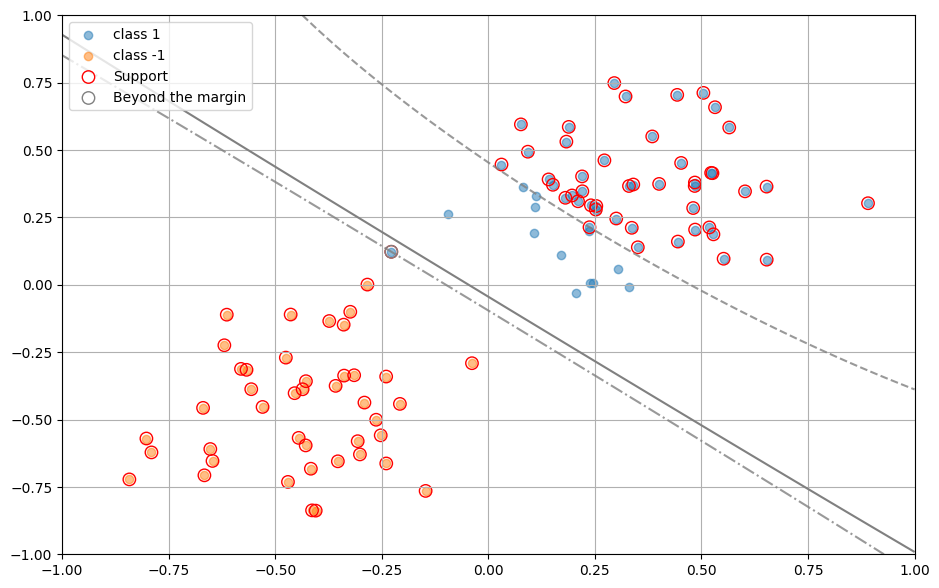

In [137]:
sigma = 1.5
C=1.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 2
#### Linear SVM

Number of support vectors = 74


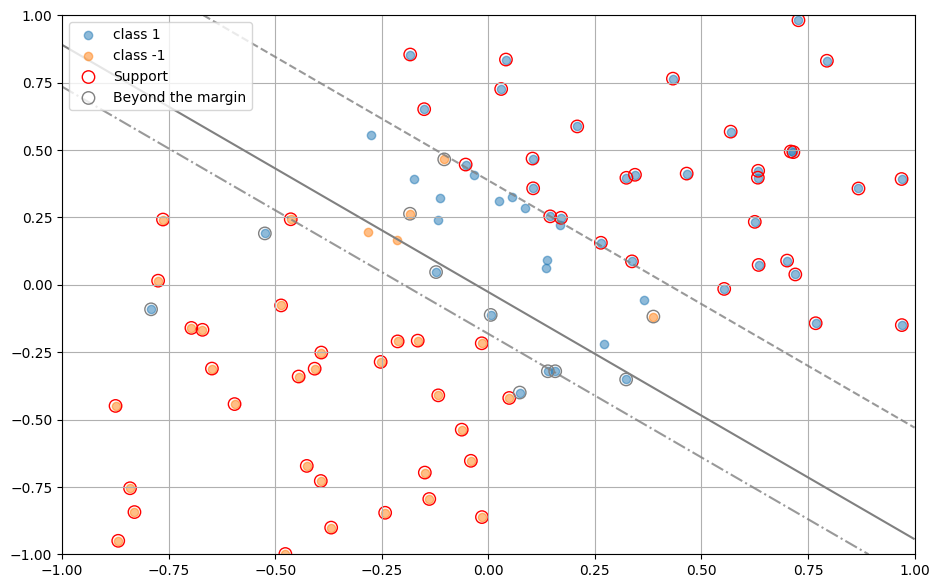

In [138]:
C=.1
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

Number of support vectors = 88


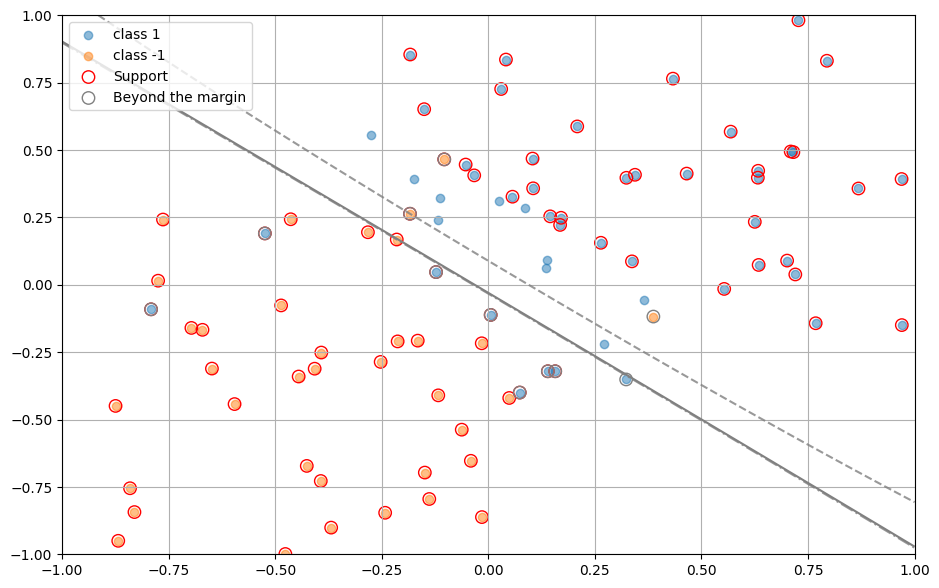

In [139]:
sigma = 1.5
C=1.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 3
#### Linear SVM

Number of support vectors = 116


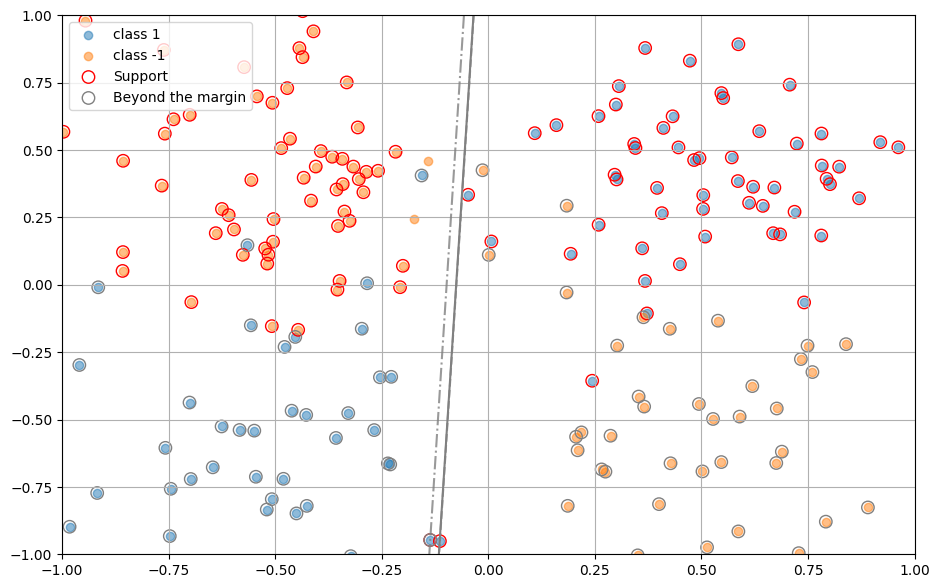

In [140]:
C=1.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

Number of support vectors = 122


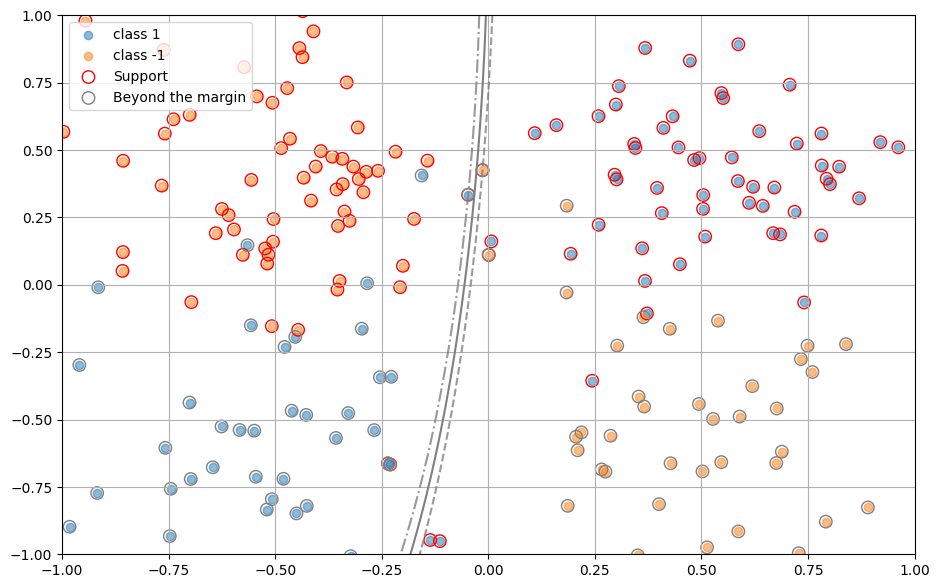

In [141]:
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')